<a href="https://colab.research.google.com/github/hhauschild/keras-playground/blob/master/liveproject_dl_predict_3_fit_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Create NN


In [1]:
# read data
import pandas as pd

gameurl = r"https://liveproject-resources.s3.amazonaws.com/other/deeplearningbasketballscores/Games-Calculated.csv"
dateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")
df = pd.read_csv(gameurl, header = None, \
                      names=["date","home_team","home_score", "away_team","away_score", \
                             "home_sc_avg", \
                             "home_defensive_avg", "away_sc_avg", "away_defensive_avg", "result" ] ,\
                      parse_dates=["date"], \
                      dtype={"home_team":str,"home_score":int,"away_team":str,\
                             "away_score":int, "home_sc_avg":float, \
                             "home_defensive_avg":float, "away_sc_avg":float,  \
                             "away_defensive_avg":float, "result":int} \
                      );
df.head()

,date,home_team,home_score,away_team,away_score,home_sc_avg,home_defensive_avg,away_sc_avg,away_defensive_avg,result
0,2015-11-13,Hawaii,87,Montana State,76,87.0,76.0,76.0,87.0,11
1,2015-11-13,Eastern Michigan,70,Vermont,50,70.0,50.0,50.0,70.0,20
2,2015-11-13,Yale,70,Fairfield,57,70.0,57.0,57.0,70.0,13
3,2015-11-13,Central Michigan,89,Jacksonville State,83,89.0,83.0,83.0,89.0,6
4,2015-11-13,Iowa State,68,Colorado,62,68.0,62.0,62.0,68.0,6


In [2]:
# encode team names
team_ids = df["home_team"].unique().tolist()
team2team_encoded = {x: i for i, x in enumerate(team_ids)}
team_encoded2team = {i: x for i, x in enumerate(team_ids)}
df["home_team_id"] = df["home_team"].map(team2team_encoded)
df["away_team_id"] = df["away_team"].map(team2team_encoded)

df.head()

,date,home_team,home_score,away_team,away_score,home_sc_avg,home_defensive_avg,away_sc_avg,away_defensive_avg,result,home_team_id,away_team_id
0,2015-11-13,Hawaii,87,Montana State,76,87.0,76.0,76.0,87.0,11,0,221
1,2015-11-13,Eastern Michigan,70,Vermont,50,70.0,50.0,50.0,70.0,20,1,182
2,2015-11-13,Yale,70,Fairfield,57,70.0,57.0,57.0,70.0,13,2,240
3,2015-11-13,Central Michigan,89,Jacksonville State,83,89.0,83.0,83.0,89.0,6,3,288
4,2015-11-13,Iowa State,68,Colorado,62,68.0,62.0,62.0,68.0,6,4,220


In [3]:
# define neural network

# build model with keras
from keras.models import Sequential 
from keras.layers import Activation, Dense
from keras import losses 
from keras import optimizers 
from keras import metrics 

model = Sequential() 
input_layer = Dense(6, activation = 'relu', input_dim = 6) 
model.add(input_layer) 
layer2 = Dense(6, activation = 'relu')
model.add(layer2)
output_layer = Dense(1, activation='sigmoid')
model.add(output_layer)

print(model.summary())


model.compile(loss='mean_squared_error', optimizer='adam')

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________
None


2. Train, Test, Validate


In [4]:
# prepare training and validation data
import numpy as np
import tensorflow as tf

df = df.sample(frac=1, random_state=42)

# input
x = df[["home_team_id", "away_team_id", "home_sc_avg", \
        "home_defensive_avg", "away_sc_avg", "away_defensive_avg"]].values

# target
df["result"] = df["result"].values.astype(np.float32)
min_result = min(df["result"])
max_result = max(df["result"])
# normalize 0..1
y = df["result"].apply(lambda x: (x - min_result) / (max_result - min_result)).values

# split: training data 70% and validation 30%
train_indices = int(0.7 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

x_val,y_val

(array([[ 40.        , 247.        ,  82.5       ,  71.5       ,
          65.5       ,  69.5       ],
        [ 69.        , 258.        ,  81.42857143,  78.78571429,
          69.45454545,  85.54545455],
        [ 88.        ,  23.        ,  78.4       ,  63.9       ,
          64.        ,  67.33333333],
        ...,
        [140.        , 322.        ,  73.        ,  57.        ,
          66.33333333,  69.66666667],
        [300.        , 213.        ,  69.        ,  60.        ,
          58.5       ,  86.25      ],
        [ 78.        ,  31.        ,  83.4       ,  70.4       ,
          63.33333333,  70.33333333]]),
 array([0.45454545, 0.62878788, 0.53787879, ..., 0.38636364, 0.50757576,
        0.53787879]))

In [5]:
# train the model

gg = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)
gg

Train on 14112 samples, validate on 6048 samples
Epoch 1/5
14112/14112 [==============================] - 0s 35us/step - loss: 0.0492 - val_loss: 0.0127
Epoch 2/5
14112/14112 [==============================] - 0s 23us/step - loss: 0.0122 - val_loss: 0.0132
Epoch 3/5
14112/14112 [==============================] - 0s 26us/step - loss: 0.0118 - val_loss: 0.0123
Epoch 4/5
14112/14112 [==============================] - 0s 25us/step - loss: 0.0117 - val_loss: 0.0127
Epoch 5/5
14112/14112 [==============================] - 0s 23us/step - loss: 0.0117 - val_loss: 0.0119


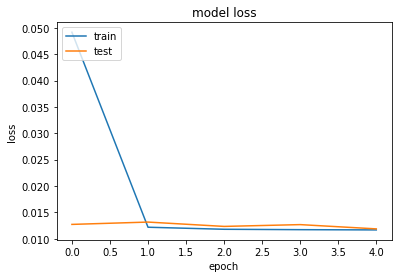

In [6]:
# plot losses
import matplotlib.pyplot as plt

plt.plot(gg.history["loss"])
plt.plot(gg.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

